In [ ]:
from fastbook import *
from fastai.vision.all import *

In [ ]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Data
Here we take only the necessary code from `05_pet_breeds.ipynb`
## Load Dog and Cat Breed Data

In [ ]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
(path/"images").ls()

(#7393) [Path('images/Birman_115.jpg'),Path('images/leonberger_142.jpg'),Path('images/Bombay_68.jpg'),Path('images/japanese_chin_26.jpg'),Path('images/saint_bernard_149.jpg'),Path('images/Ragdoll_41.jpg'),Path('images/japanese_chin_32.jpg'),Path('images/Ragdoll_68.jpg'),Path('images/Persian_202.jpg'),Path('images/scottish_terrier_143.jpg')...]

## Dataloaders

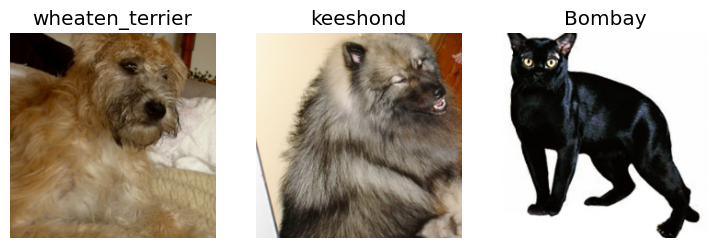

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images", bs=64)

dls.show_batch(nrows=1, ncols=3)

# Objective
Our objective is to beat the best classifier presented on the chapter which gave an error rate of 5.4% as shown here:

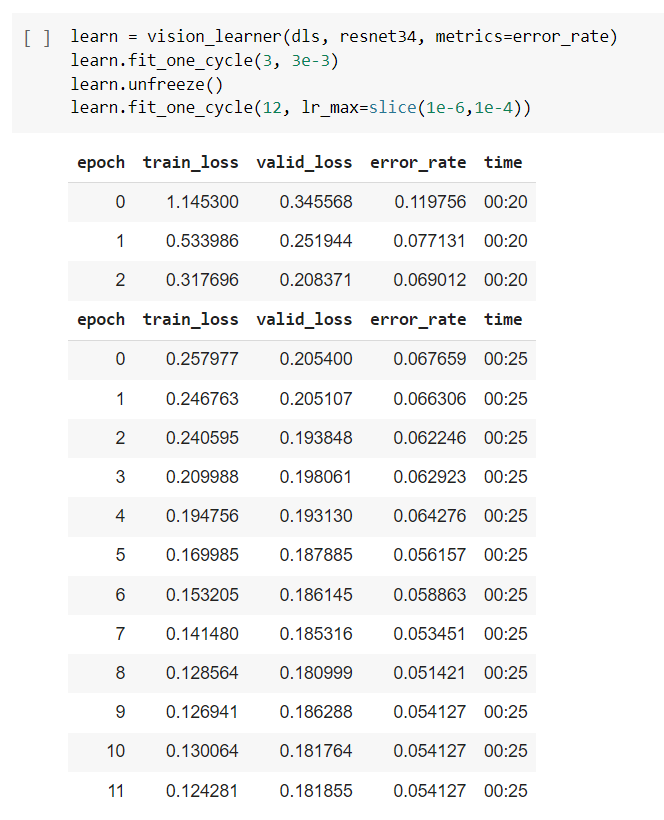

# Approach 1: Leslie N. Smith Hyperparameter Tuning Recipe

Reference: https://doi.org/10.48550/arXiv.1803.09820

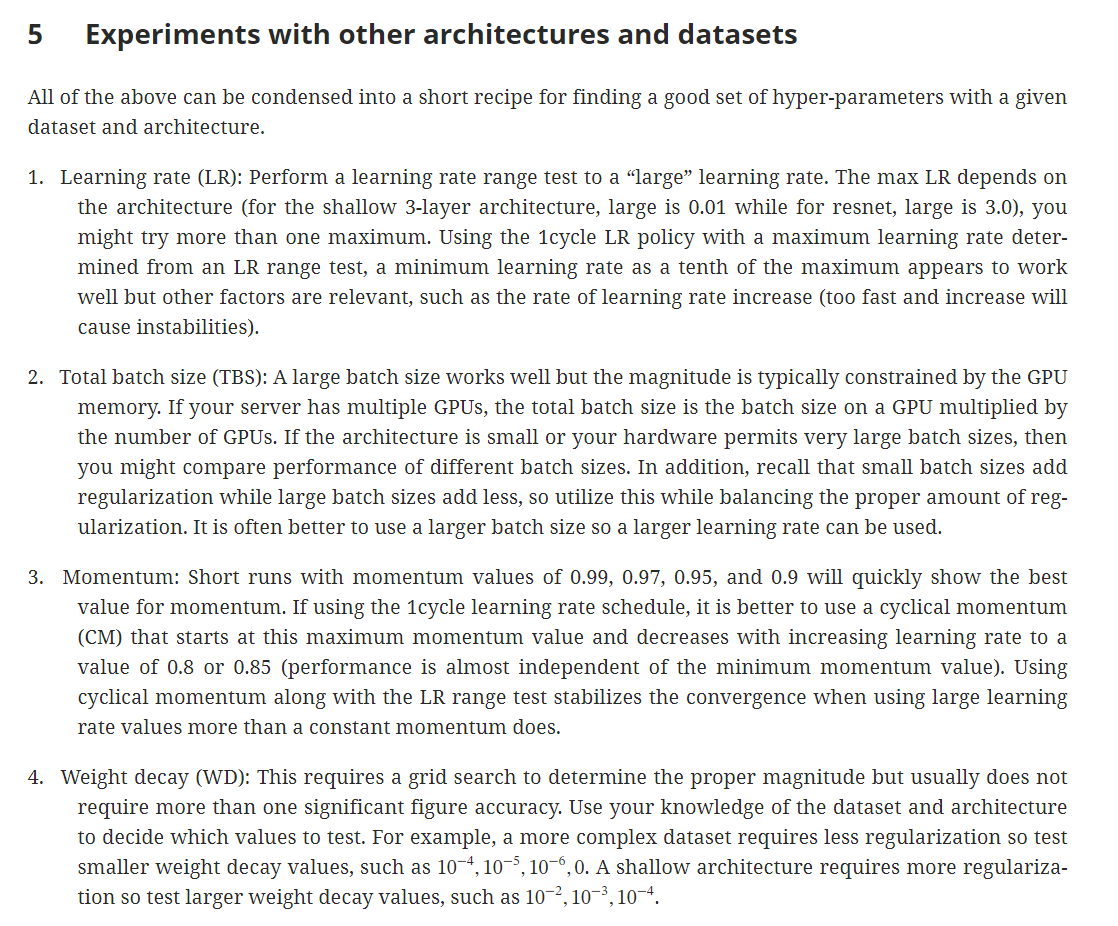

## Defaults

In [ ]:
learn_default = vision_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn_default.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.150944,0.323085,0.106225,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.518906,0.244599,0.082544,00:36
1,0.403884,0.219043,0.073748,00:36
2,0.318064,0.268967,0.079838,00:35
3,0.247518,0.250663,0.075101,00:35
4,0.192878,0.239892,0.069012,00:36
5,0.143901,0.219048,0.060893,00:36
6,0.104691,0.207031,0.061570,00:35
7,0.078952,0.205726,0.065629,00:36
8,0.058778,0.199659,0.060217,00:37
9,0.049555,0.196498,0.058863,00:37


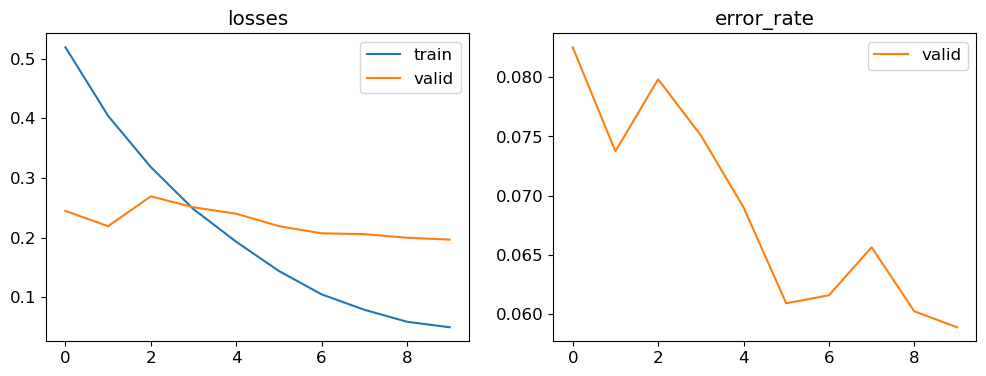

In [ ]:
learn_default.recorder.plot_metrics()

## Experiment 1: Constant Hyperparameters

### 1. Learning Rate

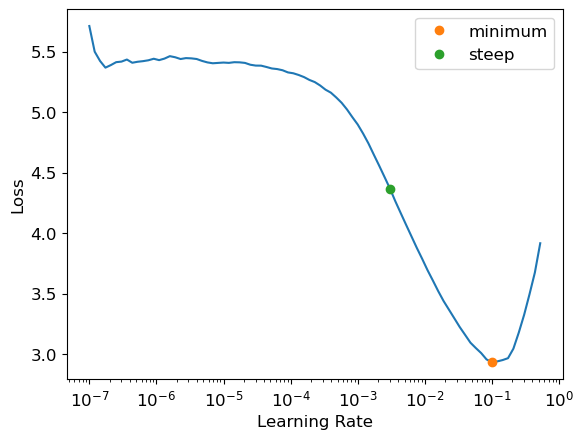

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f'lr_min / 10: {lr_min:.05f}, lr_steep: {lr_steep:.05f}')

lr_min: 0.01000, lr_steep: 0.00302


In [ ]:
# LR choice
lr = lr_min / 10
lr

0.0010000000149011613

In [ ]:
learn_const_1 = vision_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn_const_1.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.768531,0.430882,0.140054,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.771004,0.296201,0.098106,00:36
1,0.570572,0.229431,0.081191,00:36
2,0.430255,0.212741,0.074425,00:36
3,0.312866,0.199092,0.067659,00:36
4,0.242909,0.188938,0.060217,00:35
5,0.197697,0.178283,0.059540,00:35
6,0.157444,0.175552,0.059540,00:35
7,0.125463,0.167156,0.054127,00:35
8,0.102986,0.165047,0.051421,00:35
9,0.093548,0.165981,0.052774,00:37


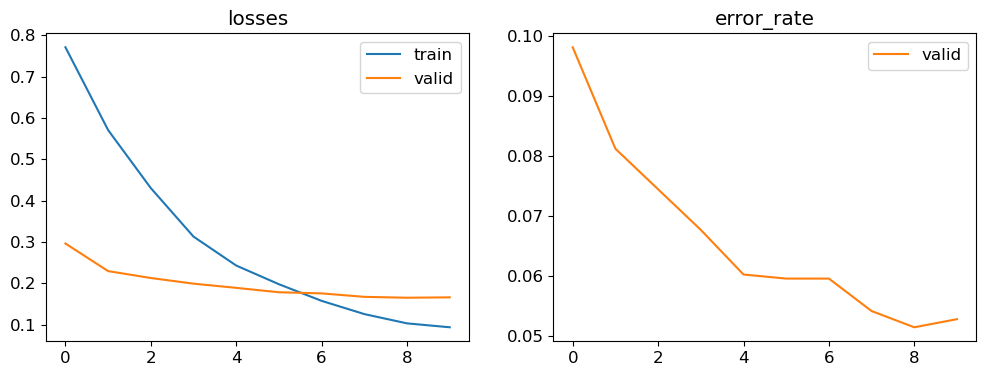

In [ ]:
learn_const_1.recorder.plot_metrics()

Across different batch sizes, lr_min / 10 works better than lr_min / 3 or lr_min. Could consider testing something smaller later.

### 2. Total Batch Size

In [ ]:
dls_128 = pets.dataloaders(path/"images", bs=128)
learn_128 = vision_learner(dls_128, resnet34, metrics=error_rate)

0.0010000000149011613

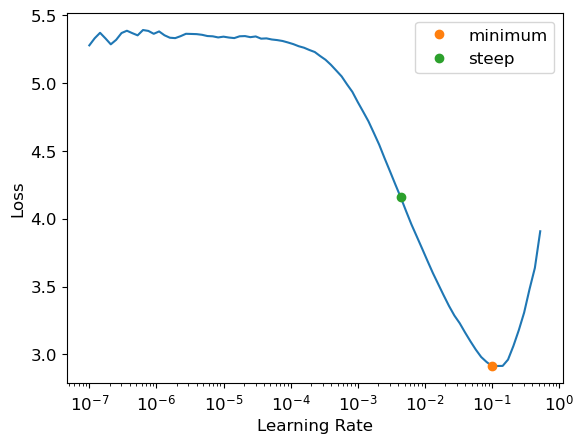

In [ ]:
lr_min, lr_steep = learn_128.lr_find(suggest_funcs=(minimum, steep))
lr = lr_min / 10
lr

In [ ]:
learn_128.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.775411,0.441257,0.134641,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.747461,0.309802,0.098782,00:36
1,0.579962,0.237408,0.083221,00:35
2,0.438783,0.203154,0.066306,00:35
3,0.326603,0.201215,0.064953,00:35
4,0.247858,0.185167,0.063599,00:35
5,0.195366,0.181396,0.057510,00:35
6,0.155223,0.176820,0.055480,00:37
7,0.125636,0.169790,0.054127,00:36
8,0.107609,0.170154,0.054804,00:35
9,0.094939,0.168354,0.052774,00:35


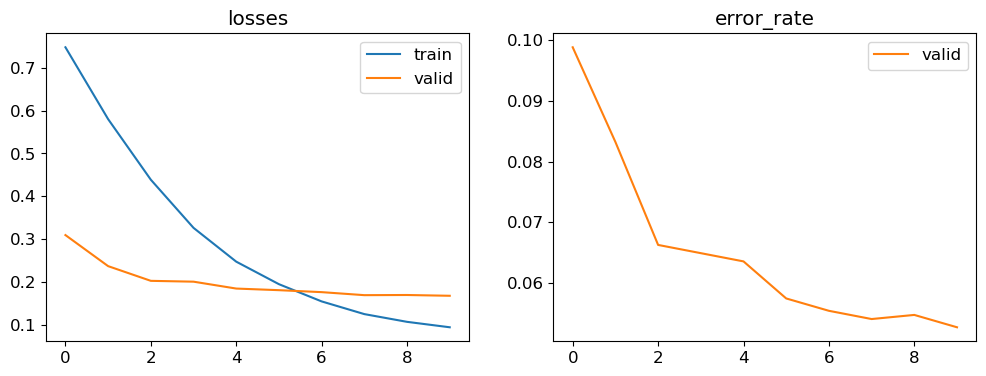

In [ ]:
learn_128.recorder.plot_metrics()

In [ ]:
dls_256 = pets.dataloaders(path/"images", bs=256)
learn_256 = vision_learner(dls_256, resnet34, metrics=error_rate)

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.0017378008365631103

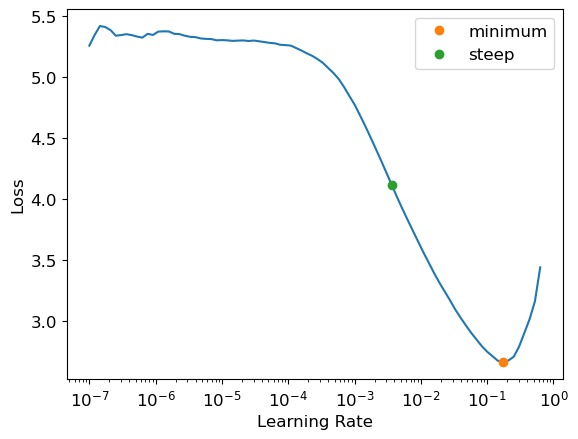

In [ ]:
lr_min, lr_steep = learn_256.lr_find(suggest_funcs=(minimum, steep))
lr = lr_min / 10
lr

In [ ]:
learn_256.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.993850,0.401531,0.132612,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.714263,0.292317,0.101489,00:47
1,0.560546,0.217750,0.075778,00:40
2,0.434790,0.207361,0.067659,00:38
3,0.343769,0.206695,0.067659,00:38
4,0.267497,0.224415,0.073748,00:38
5,0.212372,0.196636,0.062246,00:38
6,0.171168,0.189759,0.055480,00:39
7,0.136446,0.189119,0.058187,00:41
8,0.113304,0.181912,0.055480,00:41
9,0.098986,0.180835,0.055480,00:38


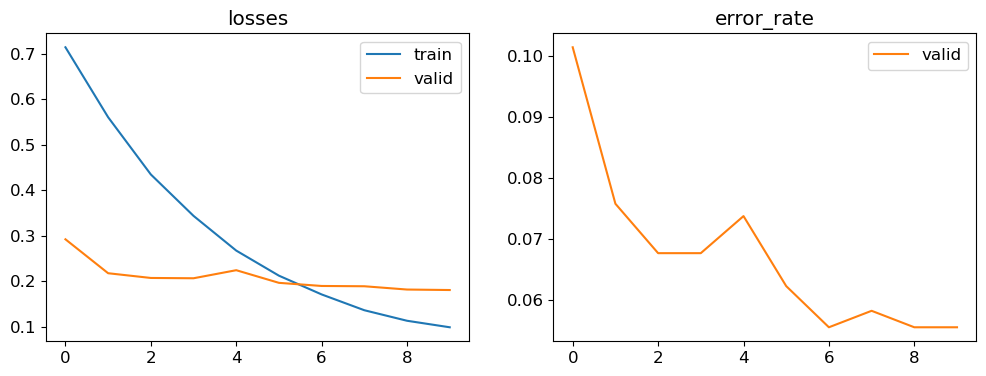

In [ ]:
learn_256.recorder.plot_metrics()

In [ ]:
# Batch size of 256 nearly maxed out GPU RAM. Can't go larger.
dls_32 = pets.dataloaders(path/"images", bs=32)
learn_32 = vision_learner(dls_32, resnet34, metrics=error_rate)

0.000831763744354248

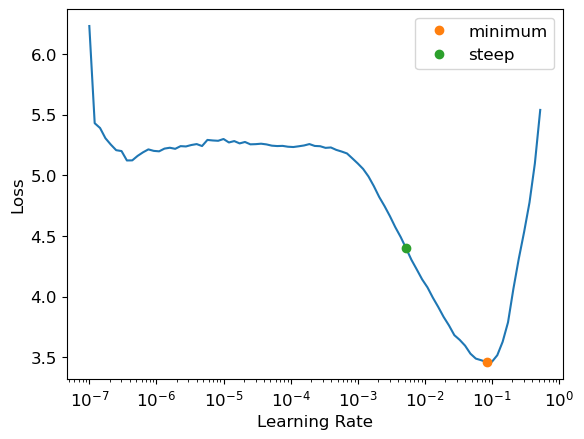

In [ ]:
lr_min, lr_steep = learn_32.lr_find(suggest_funcs=(minimum, steep))
lr = lr_min / 10
lr

In [ ]:
learn_32.fine_tune(10, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.389215,0.364806,0.116373,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.628751,0.252162,0.083897,00:39
1,0.485322,0.230270,0.079161,00:38
2,0.394205,0.225712,0.075101,00:38
3,0.315702,0.226441,0.071719,00:39
4,0.244532,0.211168,0.064953,00:38
5,0.191883,0.185990,0.057510,00:39
6,0.124685,0.181733,0.058863,00:40
7,0.136134,0.164471,0.052097,00:38
8,0.094243,0.161639,0.051421,00:39
9,0.082327,0.167359,0.056834,00:40


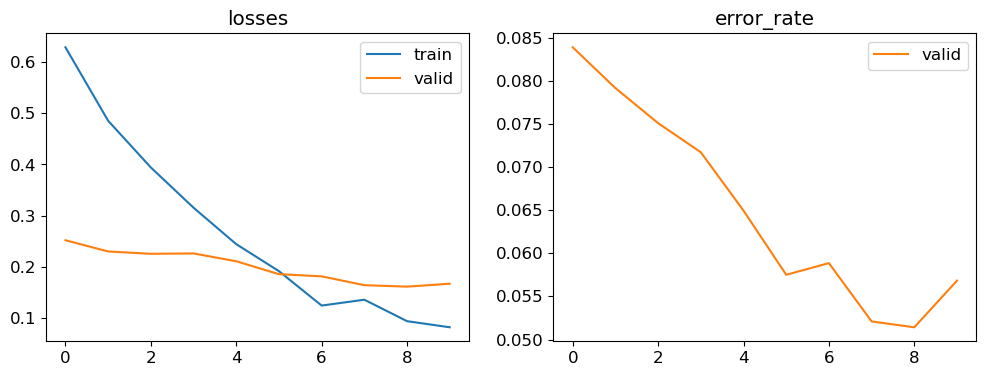

In [ ]:
learn_32.recorder.plot_metrics()

No big difference. 64 or 128 seem fine. Maybe 128 is a bit more stable

### 3. Momentum

In [ ]:
bs = 128
lr = 0.0010000000149011613

dls = pets.dataloaders(path/"images", bs=bs)
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn.fine_tune(10, base_lr=lr, moms=(0.99, 0.9, 0.85))

epoch,train_loss,valid_loss,error_rate,time
0,3.042745,0.483617,0.153586,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.821662,0.342117,0.108254,00:38
1,0.630207,0.248499,0.080514,00:34
2,0.455258,0.221145,0.077808,00:34
3,0.346733,0.190916,0.065629,00:35
4,0.264620,0.193630,0.062923,00:34
5,0.200492,0.196173,0.066306,00:34
6,0.161878,0.173382,0.059540,00:34
7,0.132633,0.174968,0.058187,00:34
8,0.111284,0.175282,0.056834,00:35
9,0.102591,0.172050,0.054804,00:36


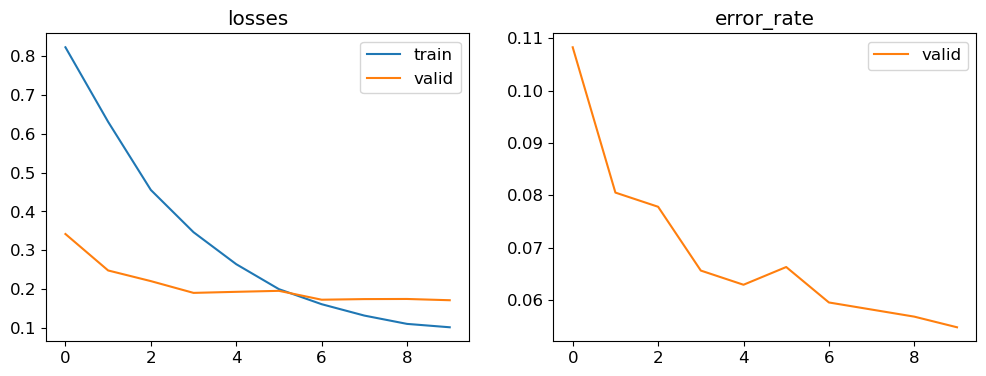

In [ ]:
learn.recorder.plot_metrics()

### 4. Weight Decay

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10, base_lr=lr, wd=1e-4)

/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shudso/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.869221,0.439438,0.135995,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.754469,0.311246,0.101489,00:35
1,0.564631,0.237100,0.082544,00:34
2,0.425055,0.235367,0.078484,00:35
3,0.331380,0.206459,0.073072,00:37
4,0.251123,0.181340,0.056157,00:34
5,0.183918,0.177001,0.054804,00:35
6,0.147139,0.169558,0.050068,00:34
7,0.126101,0.169033,0.050068,00:35
8,0.104032,0.165314,0.047361,00:35
9,0.099779,0.165624,0.048038,00:34


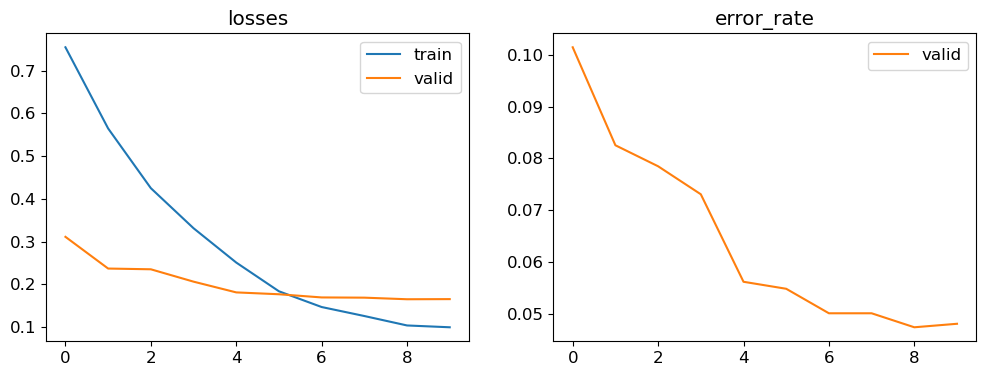

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10, base_lr=lr, wd=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.908278,0.467207,0.148173,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.746175,0.329252,0.110284,00:35
1,0.567659,0.249337,0.084574,00:35
2,0.437376,0.217497,0.073072,00:34
3,0.318975,0.216536,0.073072,00:34
4,0.252999,0.205212,0.075101,00:34
5,0.202792,0.193878,0.059540,00:35
6,0.156868,0.184448,0.057510,00:34
7,0.128337,0.182746,0.054127,00:34
8,0.108313,0.180002,0.054804,00:34
9,0.096433,0.178159,0.054127,00:35


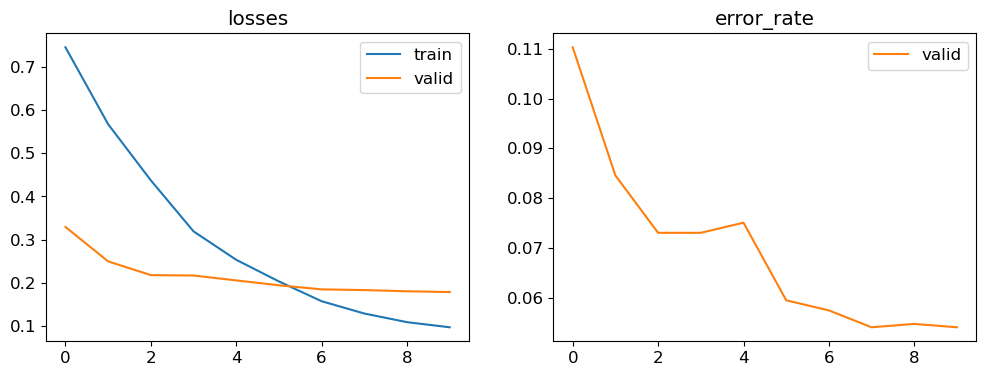

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
 learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10, base_lr=lr, wd=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.840021,0.446969,0.138701,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.759528,0.306520,0.096752,00:36
1,0.571788,0.230974,0.077808,00:36
2,0.432307,0.218439,0.076455,00:35
3,0.320587,0.198591,0.066306,00:35
4,0.259636,0.194848,0.067659,00:36
5,0.196176,0.174783,0.057510,00:36
6,0.147848,0.169008,0.056834,00:35
7,0.126753,0.170739,0.057510,00:35
8,0.114850,0.164995,0.056157,00:35
9,0.100525,0.165858,0.057510,00:35


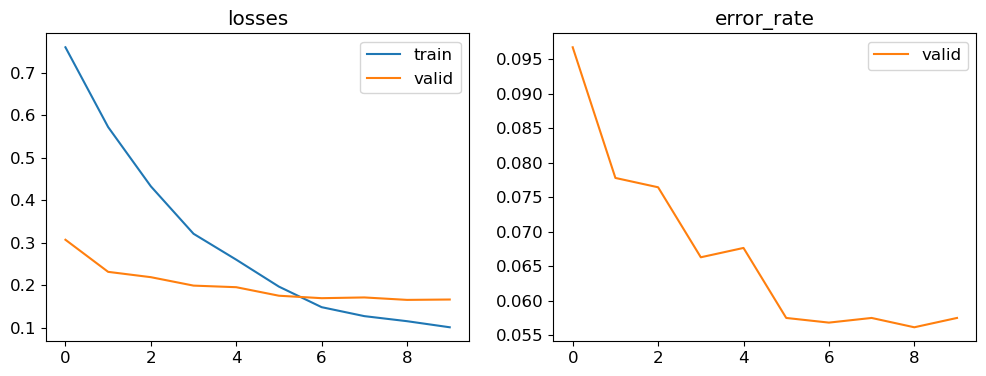

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.show_results()